In [148]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [149]:
# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径（效果不好）
"""
t取数千
"""
def compute_avg_radius(n, distances): 
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    np.savetxt('avg_radius.csv', radius, delimiter=',') # 保存每个数据点的平均邻域半径
    return radius

In [150]:
# 以将距离从小到大排序后的第k个距离作为每个数据点的半径(几乎等同于KNN)
"""
参数接近KNN
"""
def compute_k_maximun_radius(n, distances, k):
    radius = np.zeros(n)
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    for i in range(n):
        # 选取第k个距离作为半径
        radius[i] = sorted_distances[i, k]
    np.savetxt('k_maximun_radius.csv', radius, delimiter=',')  # 保存每个数据点的半径
    return radius

In [151]:
# 以将距离从小到大排序后前k个距离的平均值作为每个数据点的半径(效果还行)
"""
参数接近KNN
"""
def compute_knn_average_radius(distances, k):
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    avg_knn_distances = np.mean(sorted_distances[:, 1:k+1], axis=1)  # 计算每个数据点的前k个距离的平均值作为半径
    np.savetxt('avg_knn_distances.csv', avg_knn_distances, delimiter=',')
    return avg_knn_distances

In [152]:
def compute_avg_shortest_path(distances, knn_adjacency_matrix):
    n = distances.shape[0]
    avg_shortest_paths = np.zeros(n)  # 存储每个数据点到其他所有点的最短路径的平均值
    
    # 使用Floyd-Warshall算法计算所有节点对之间的最短路径
    all_shortest_paths = floyd_warshall(distances, knn_adjacency_matrix)
    
    # 计算每个数据点到其他所有点的最短路径的平均值
    for i in range(n):
        avg_shortest_paths[i] = np.mean(all_shortest_paths[i])
    np.savetxt('avg_shortest_paths.csv', avg_shortest_paths, delimiter=',')  # 保存每个数据点到其他所有点的最短路径的平均值
    return avg_shortest_paths

def floyd_warshall(distances, adjacency_matrix):
    n = distances.shape[0]
    all_shortest_paths = np.zeros((n, n))
    all_shortest_paths.fill(np.inf)
    
    # 初始化所有节点对之间的直接距离
    all_shortest_paths[adjacency_matrix == 1] = distances[adjacency_matrix == 1]
    
    # Floyd-Warshall算法核心步骤
    for k in range(n):
        for i in range(n):
            for j in range(n):
                all_shortest_paths[i, j] = min(all_shortest_paths[i, j], all_shortest_paths[i, k] + all_shortest_paths[k, j])
    
    return all_shortest_paths


In [153]:
from scipy.interpolate import interp1d
import numpy as np

def compute_adaptive_neighbors(Data):
    n = Data.shape[0]
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    sorted_distances = np.sort(distances, axis=1)
    adaptive_neighbors = np.zeros((n, 1))
    np.savetxt('sorted_distances.csv', sorted_distances, delimiter=',')
    np.savetxt('adaptive_neighbors.csv', adaptive_neighbors, delimiter=',')
    # 对每行距离进行插值和求导
    for i in range(n):
        # 对距离进行插值，生成连续的函数
        f = interp1d(np.arange(n), sorted_distances[i], kind='linear')
        #coefficients = np.polyfit(np.arange(n), sorted_distances[i], deg=5)  # 使用6次多项式拟合
        #f = np.poly1d(coefficients)  # 构建多项式函数
        # 求导
        df = np.gradient(f(np.arange(n)))  # 计算函数的导数
        # 寻找导数为1的位置
        idx = np.where(df <= 1)[0][0]
        # 将索引保存为每个数据点的邻居数量
        adaptive_neighbors[i] = idx
    np.savetxt("adaptive_neighbors.csv", adaptive_neighbors, delimiter=",")
    return adaptive_neighbors, sorted_distances, distances

# 根据adaptive_neighbors中每一行的邻居数量和sorted_distances对每个数据点构建epsilon graph
def adaptive_epsilon_graph(Data):
    adaptive_neighbors, sorted_distances, distances = compute_adaptive_neighbors(Data)
    n = Data.shape[0]
    adaptive_epsilon_adjacency_matrix = np.zeros((n, n))
    for i in range(n):
        indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]
        adaptive_epsilon_adjacency_matrix[i, indices] = 1
        adaptive_epsilon_adjacency_matrix[indices, i] = 1
    return adaptive_epsilon_adjacency_matrix, distances

def knn_graph(Data, method, k):
    # 获取样本点的数量
    n = Data.shape[0]
    # 初始化k近邻图的邻接矩阵
    knn_adjacency_matrix = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

# 计算k最近邻接矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix = np.zeros((n, n))
        radius = compute_knn_average_radius(distances, k)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= radius[i])[0]  # 获取epsilon邻域内的样本索引
            adjacency_matrix[i, neighbors] = 1
            adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances
    elif method == 'adaptive_epsilon':
        adaptive_epsilon_adjacency_matrix, distances = adaptive_epsilon_graph(Data)
        return adaptive_epsilon_adjacency_matrix, distances


# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, k, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    # 计算相似度矩阵
    similarity_matrix = np.exp(-distances ** 2 / t)
    # 将相似度矩阵按照邻接矩阵进行筛选，得到需要设置权重的位置
    i_indices, j_indices = np.where(adjacency_matrix == 1)
    # 设置权重
    Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]  # 对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵的原理是利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    print('adjacency_matrix:', adjacency_matrix.shape)
    print('Weight_matrix:', Weight_matrix.shape)
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix               

In [154]:
def LPP(Data, method, d, k, t):
    """
    进行LPP算法，得到特征映射后的数据集

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - d: 降维后的维度
    - k: 最近邻的数量
    - t: 高斯核函数的参数

    Returns:
    - selected_eigenvectors: 特征映射后的数据集
    """
    # Step 1: 计算权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, k, t)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 求解特征向量
    eigenvalues, eigenvectors = eigs(Laplacian_matrix, k=d+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors

In [155]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)
'''
# 绘制三维数据集
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))
ax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))
ax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))
plt.title('Data - '+ str(Data.shape[1]) + ' points', size=30)
ax.axis("off")
'''

'\n# 绘制三维数据集\nfig = plt.figure(figsize=(14,10))\nax = fig.add_subplot(111, projection="3d")\nax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)\nax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))\nax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))\nax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))\nplt.title(\'Data - \'+ str(Data.shape[1]) + \' points\', size=30)\nax.axis("off")\n'

C:\Users\Tony\AppData\Local\Temp\ipykernel_14496\1397569048.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]


adjacency_matrix: (1000, 1000)
Weight_matrix: (1000, 1000)
(1000, 2)


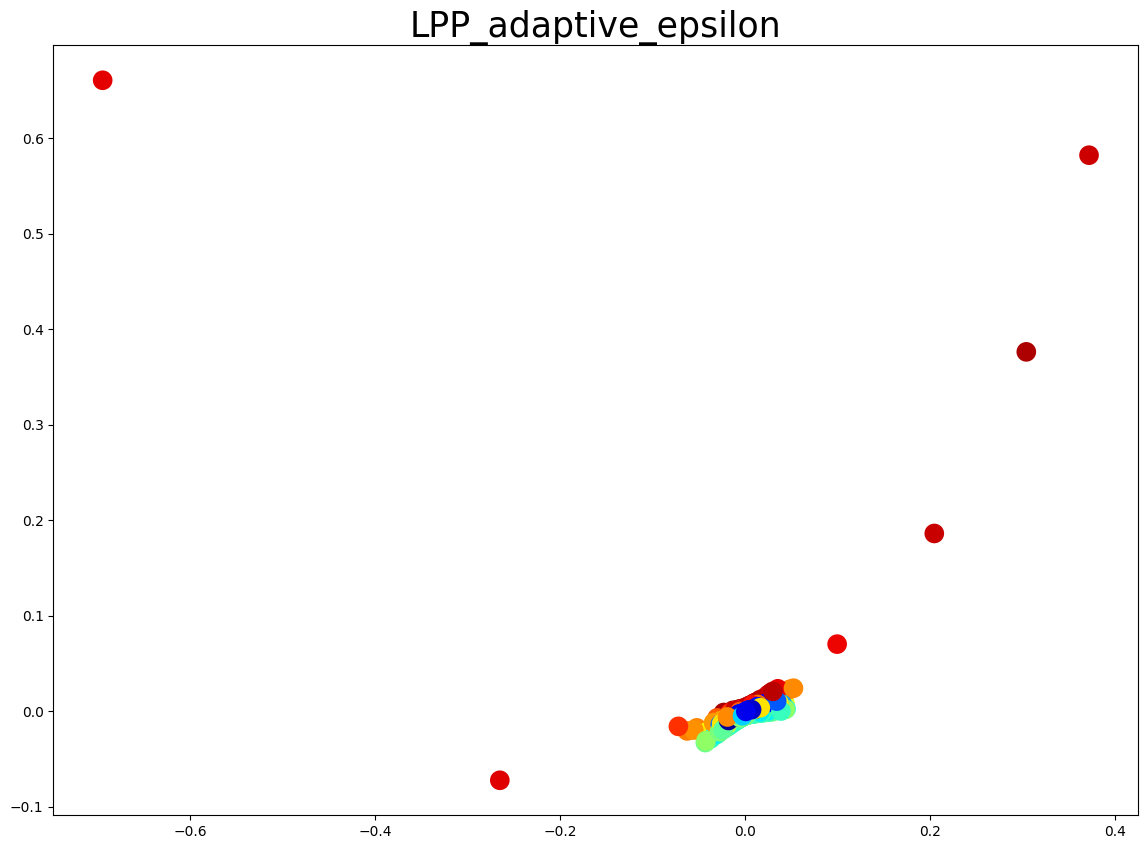

adjacency_matrix: (1000, 1000)
Weight_matrix: (1000, 1000)
(1000, 2)


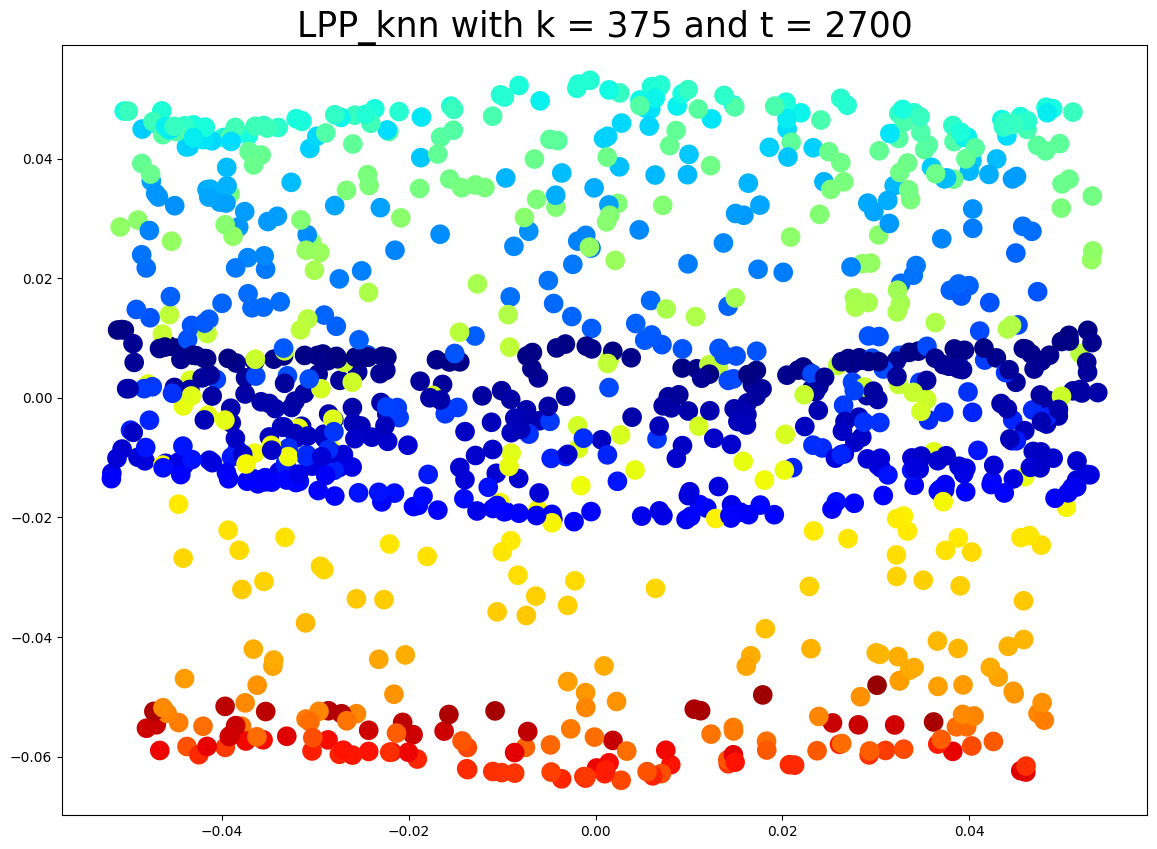

adjacency_matrix: (1000, 1000)
Weight_matrix: (1000, 1000)
(1000, 2)


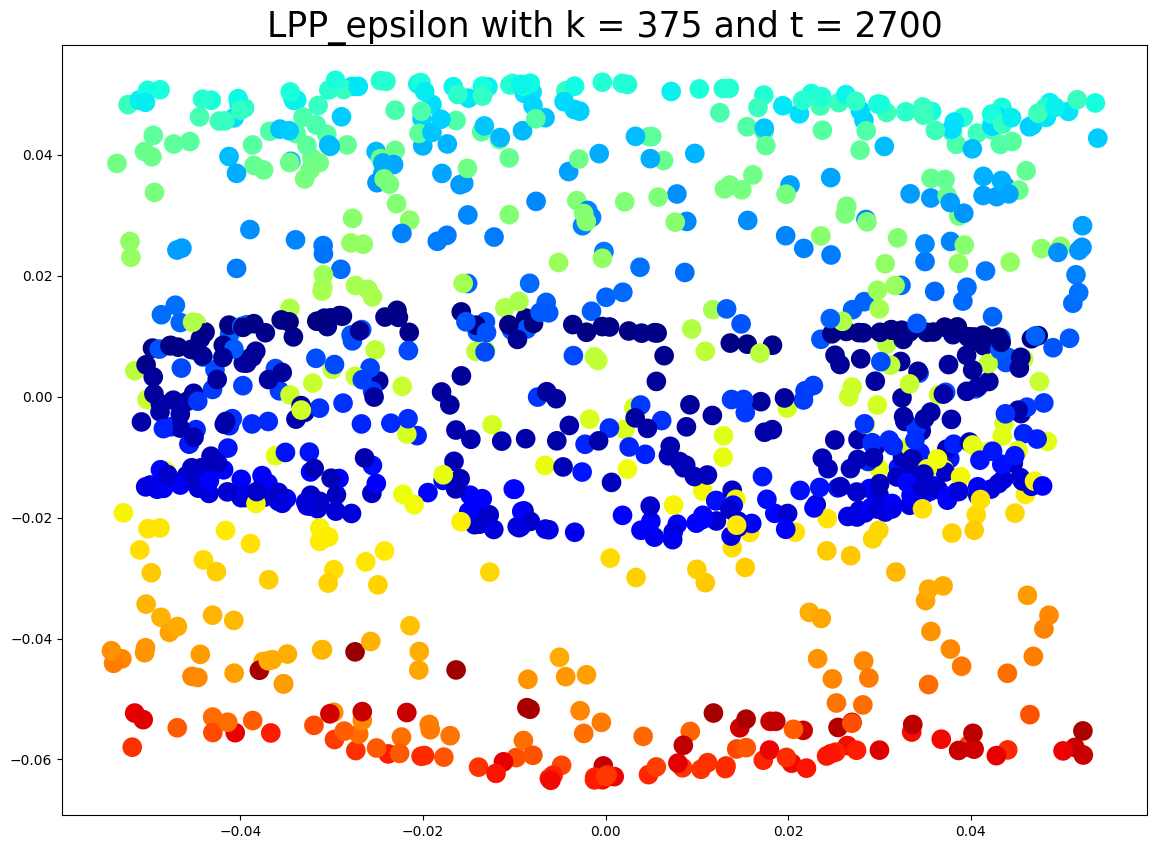

In [156]:
# 绘制及保存投影图
if not os.path.exists('output'):
    os.makedirs('output')
for method in ['adaptive_epsilon', 'knn', 'epsilon']:
    plt.figure(figsize=(14, 10))
    if method == 'epsilon':
        k = 375
        t= 2700
        lpp_embeddings = LPP(Data_T, d=2, method=method, k=k, t=t)
        print(lpp_embeddings.shape)
        plt.title('LPP_epsilon with k = ' + str(k) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_epsilon_t = ' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    elif method == 'knn':
        k = 375
        t= 2700
        lpp_embeddings = LPP(Data_T, d=2, method=method, k=k, t=t)
        print(lpp_embeddings.shape)
        plt.title('LPP_knn with k = ' + str(k) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_knn_' + str(k) + '_t=' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    elif method == "adaptive_epsilon":
        k = 375
        t= 2700
        lpp_embeddings = LPP(Data_T, d=2, method=method, k=k, t=t)
        print(lpp_embeddings.shape)
        plt.title('LPP_adaptive_epsilon', size=25)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
    plt.show()

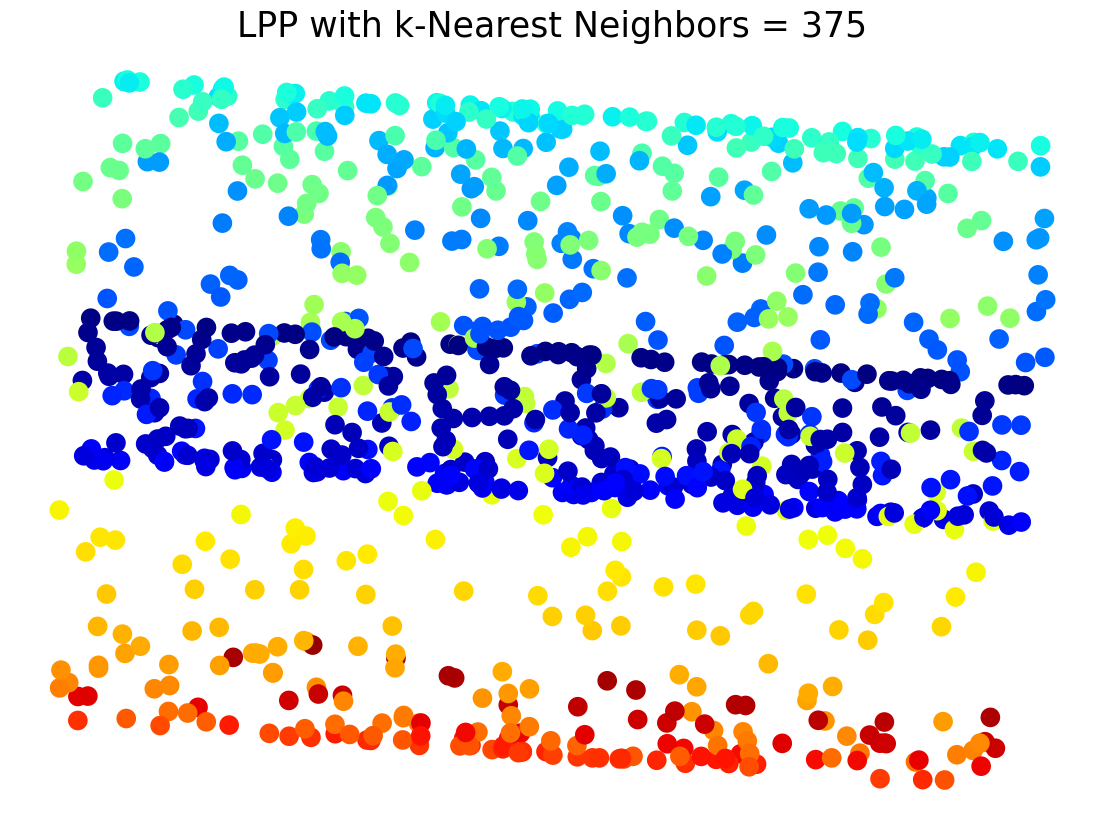

In [157]:
from lpproj import LocalityPreservingProjection
#创建 LPP 模型
lpp = LocalityPreservingProjection(n_neighbors=k, n_components= 2)
# 使用 LPP 模型拟合瑞士卷数据集
lpp.fit(Data_T)
# 将数据集进行降维处理
y = lpp.transform(Data_T)

# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(y[:, 0], y[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(k), size=25)
plt.axis("off")
plt.show()